In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#Importing necessary packages
!pip install shutup
!pip install keras_preprocessing
import shutup
shutup.please()
import json
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense,Bidirectional, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import os, re
import nltk
nltk.download('punkt')
from tqdm import tqdm_notebook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


*Text Extraction*

In [ ]:
#Reading json files
read_path = r"drive/MyDrive/nlp/pdf_json1180"
files = os.listdir(read_path)
print("No. of files taken as input: ",len(files))

No. of files taken as input:  1180


In [ ]:
# Extracting abstracts.

def extract_abstract(filename :str ) -> str :
  file = open(filename)
  paper_content = json.load(file)
  abstract = ""
  if 'abstract' in paper_content:
        for abs in paper_content['abstract']:
            abstract = abstract + abs['text']
  return (abstract + ' ' + '\n').lower()

In [ ]:
import re
def preprocessing(text):

  if "\n" in text:
    text = text.replace("\n","")


    # Converting abstracts to lower case
    text=text.lower()

    # Removing citations
    cit_pattern = re.compile(r'\[\d+(,[ \t]\d+)\]')
    text = cit_pattern.sub(r'', text)

    # Removing URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)

    # Removing email
    email_pattern = re.compile(r'''([-!#-'+/-9=?A-Z^-~]+(\.[-!#-'+/-9=?A-Z^-~]+)|"([]!#-[^-~ \t]|(\\[\t -~]))+")@([-!#-'+/-9=?A-Z^-~]+(\.[-!#-'+/-9=?A-Z^-~]+)|\[[\t -Z^-~]*])''')
    text = email_pattern.sub(r'', text)

    # Removing punctuations
    punct_pattern = re.compile(r'[^\w\s]')
    text= punct_pattern.sub(r'', text)

    # Replacing multiple occurences of space with a single space
    text=re.sub("\s*\s"," ",text)

    words=text.split(" ")
    words=[i for i in words if i!='']

    return words

In [ ]:
doc_words = []
for i in tqdm_notebook(range(300)):
  c = preprocessing(extract_abstract(read_path + '/' + files[0]))
  doc_words.extend(c)

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
print("Vocabulary size: ",len(doc_words))

Vocabulary size:  37800


In [ ]:
# In case of RAM issue, take a subset of words from doc_words, run the command to delete the vocab array.

# del doc_words

In [ ]:
#Basic Preprocessing

processed = []
for i in doc_words:
  if i.isalnum() == True:
    processed.append(i)
print(len(processed))

37800


*Encoding layer for feeding into LSTM*

In [ ]:
# processed = processed[:5000]
print(len(processed))
tokenizer = Tokenizer(num_words=1000)
def create_feed_matrix(docs = processed, window = 15):
  beg = 0
  text2num, pred = [],[]
  word_seq = []
  while(beg < len(docs) - (window + 1)):
    sentence = docs[beg:beg + window + 1]
    word_seq.append(sentence)
    beg+=1
  tokenizer.fit_on_texts(word_seq)
  for i in word_seq:
    sequences = tokenizer.texts_to_sequences(i)
    if [] not in sequences:
      seq = [i[0] for i in sequences]
      text2num.append(seq)
    else:
      pass
  return text2num
seq_mat = create_feed_matrix()

37800


In [ ]:
# Generating input sequences and correspoding labels

input_seq = [i[:-1] for i in seq_mat]
label = [i[-1] for i in seq_mat]

In [ ]:
# Creating the Bidirectional LSTM model

def create_model(vocabulary_size, seq_len, model_params = [150,150]):
    model = Sequential()
    model.add(Embedding(vocabulary_size, 25, input_length=seq_len))
    model.add(LSTM(model_params[0], return_sequences=True))
    model.add(Dropout(0.12))
    model.add(LSTM(model_params[1]))
    model.add(Dropout(0.08))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(vocabulary_size, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
# Converting sequences into suitable input formats for LSTM

X = np.array(input_seq)
labels = np.array(label)
y=to_categorical(labels,num_classes=len(labels))
win_len = 15

# # Initialising the LSTM model with two layers consisting of 200 neurons in each layer

model = create_model(y.shape[0], win_len, [200,200])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 25)            944600    
                                                                 
 lstm (LSTM)                 (None, 15, 200)           180800    
                                                                 
 dropout (Dropout)           (None, 15, 200)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 150)               30150     
                                                                 
 dense_1 (Dense)             (None, 37784)             5

In [ ]:
y.shape

(37784, 37784)

In [ ]:
# Training the LSTM model upto 60 epochs. More epochs have a risk of overfitting. Early stopping can be used.

history = model.fit(X , y ,batch_size = 30, epochs = 10 ,verbose = 1)

Epoch 1/10
1260/1260 [==============================] - 36s 20ms/step - loss: 4.2504 - accuracy: 0.0663
Epoch 2/10
1260/1260 [==============================] - 27s 22ms/step - loss: 4.1299 - accuracy: 0.0689
Epoch 3/10
1260/1260 [==============================] - 25s 20ms/step - loss: 4.1208 - accuracy: 0.0708
Epoch 4/10
1260/1260 [==============================] - 24s 19ms/step - loss: 3.1214 - accuracy: 0.2332
Epoch 5/10
1260/1260 [==============================] - 24s 19ms/step - loss: 0.2381 - accuracy: 0.9307
Epoch 6/10
1260/1260 [==============================] - 23s 18ms/step - loss: 0.0377 - accuracy: 0.9873
Epoch 7/10
1260/1260 [==============================] - 23s 18ms/step - loss: 0.0166 - accuracy: 0.9943
Epoch 8/10
1260/1260 [==============================] - 21s 17ms/step - loss: 0.0146 - accuracy: 0.9962
Epoch 9/10
1260/1260 [==============================] - 19s 15ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 10/10
1260/1260 [==============================] - 21s 16m

Using the LSTM model, we managed to reach an accuracy of 99.72%.

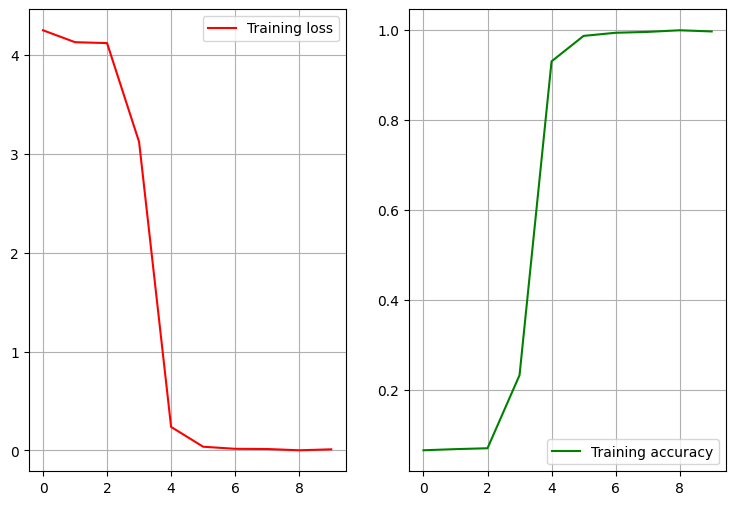

In [ ]:
# Plot metrics post training the LSTM network

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [9,6]
def plot_metrics(m1, m2):
  plt.subplot(1,2,1)
  plt.plot(history.history[str(m1)], label='Training ' + str(m1), color = "red")
  plt.legend()
  plt.grid()
  plt.subplot(1,2,2)
  plt.plot(history.history[str(m2)], label='Training ' + str(m2), color = "green")
  plt.legend()
  plt.grid()
  plt.show()
plot_metrics('loss', 'accuracy')

**Decoding layer** - *Decodes the generated text after training the LSTM model.*

In [ ]:
#Generates new text from given abstract
def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    output_text = []
    input_text = seed_text
    for i in range(num_gen_words):
      encoded_text = tokenizer.texts_to_sequences([input_text])[0]
      pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
      pred_word_ind = np.argmax(model.predict(pad_encoded, verbose=0)[0])
      pred_word = tokenizer.index_word[pred_word_ind]
      input_text += ' ' + pred_word
      output_text.append(pred_word)
    return ' '.join(output_text)

**Find is a list containing 100 most commonly used words in the English Language**

In [ ]:
import random
find = ['the', 'my', 'of', 'use', 'and', 'would', 'first', 'a', 'from', 'like', 'been', 'in', 'or', 'she', 'one', 'do', 'into', 'who', 'you', 'had', 'that', 'by', 'their', 'has', 'its', 'it', 'word', 'if', 'look', 'now', 'will', 'two', 'find', 'more', 'long', 'for', 'what', 'other', 'write', 'down', 'on', 'all', 'about', 'go', 'day', 'are', 'were', 'out', 'see', 'did', 'as', 'we', 'many', 'number', 'get', 'with', 'when', 'then', 'no', 'come', 'his', 'your', 'them', 'way', 'made', 'they', 'can', 'these', 'could', 'may', 'I', 'said', 'so', 'people', 'part', 'at', 'there', 'some', 'be', 'her', 'than', 'this', 'an', 'have', 'each', 'make', 'to', 'which', 'him', 'but', 'was', 'not', 'up', 'call', 'is']
# selects random words from the vocabulary, not including the most common words

def select_random_wrd(size = 10, commons = find, vocab = processed):
  fresh, UpdatedList = [],[]
  while len(fresh) < 10:
    UpdatedList = random.choices(processed, k = size)
    for i in UpdatedList:
      if i in commons:
        pass
      else:
        fresh.append(i)
  return fresh
wrd_list = list(set(select_random_wrd()))
fresh_wrd_list = [i for i in wrd_list if len(i) > 5]
fresh_wrd_list

['cabbage',
 'activity',
 'demonstrated',
 'oxysporum',
 'chromatographic',
 'binding',
 'reverse',
 'peptide',
 'thermostability',
 'stability',
 'antifungal',
 'arachidicola']

In [ ]:
# shows generated text results for each word derived from the corpus itself

def show_results_for_wrd(num_words = 50):
  for wrd in fresh_wrd_list[:6]:
    out_sent =generate_text(model,tokenizer,seq_len = 15,seed_text=wrd,num_gen_words=num_words)
    print("Actual word:-", wrd)
    print("\n")
    print("Generated sentence :-",out_sent)
    print("\n")
print("\n")
print("*" * 150)
print("\n")
show_results_for_wrd(30)



******************************************************************************************************************************************************


Actual word:- cabbage


Generated sentence :- adsorbed on the first three chromatographic media it exerted an inhibitory action on mycelial growth including fusarium oxysporum and mycosphaerella arachidicola with an ic 50 of 51 μm and 44


Actual word:- activity


Generated sentence :- an 94kda antifungal peptide designated as campesin was isolated from seeds of the cabbage brassica campestris the isolation procedure involved affinity chromatography on affigel blue gel ion exchange chromatography on


Actual word:- demonstrated


Generated sentence :- as campesin was isolated from seeds of the cabbage brassica campestris the isolation procedure involved affinity chromatography on affigel blue gel ion exchange chromatography on qsepharose and mono s and


Actual word:- oxysporum


Generated sentence :- and qsepharose and mono s and ge

In [ ]:
# Try for random words outside corpus

ved = str(input("Hi!, \nEnter a prompt "))
print("\n")
print("*" * 200)
print("\n")
print(generate_text(model,tokenizer,seq_len = 15,seed_text=ved,num_gen_words=20))


Hi!, 
Enter a prompt Srijit


********************************************************************************************************************************************************************************************************


was adsorbed on the first three chromatographic media it exerted an inhibitory action on mycelial growth including fusarium oxysporum and
